МФТИ: Data Mining in Action (осень, 2016)

* Дмитрий Персиянов, <dmitry.persiyanov@gmail.com>, https://vk.com/persiyanov
* Арсений Ашуха, <ars.ashuha@gmail.com>, https://vk.com/ars.ashuha

<h1 align='center'>Домашнее задание №1: линейные модели, бустинг</h1>

**Дополнительный материал для выполнения дз**:

*Линейные модели*:
- Лекция 2, DMIA: https://goo.gl/luURTu
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/

*Бустинг*:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU, 10 Boosting and Additive Trees 337
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ, http://goo.gl/ajNTQy



**Оформление дз**: 
- Присылайте выполненное задание на почту ``datamininginaction@gmail.com``
- Укажите тему письма в следующем формате ``DMIA2016_fall <направление> <фамилия>_<имя> HW1``, к примеру -- ``DMIA2016_fall trends ivanov_ilya HW1``

**Вопросы**:
- Задавайте вопросы в issues на гитхабе: https://github.com/vkantor/MIPT_Data_Mining_In_Action_2016/issues
- Либо в группу или нам в личные сообщения: https://vk.com/data_mining_in_action
------------

<h1 align='center'>Overview</h1>

На последней лекции вы узнали про классические модели машинного обучения, которые каждый Data Scientist должен знать и понимать, как они работают.

В этом домашнем задании мы предлагаем вам реализовать две модели: одну линейную -- логистическую регрессию, и модель бустинга над деревьями, а также сравнить их качество на одном датасете.

-----------

<h1 align='center'>Part 1: Logistic Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
print train_df.shape

(110163, 3)


In [4]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [5]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [6]:
train_df.tail()

,ID,Reviews_Summary,Prediction
110158,486256,Terrible!,0
110159,199050,"Cheap Coffee, No Banana Flavor",0
110160,278179,Not as described,0
110161,87500,Tastes like a squirt of toothpaste mixed into ...,0
110162,121963,Disappointed,0


----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи вам необходимо написать код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация для решения задачи:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используйте данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

In [7]:
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

In [8]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуйте ```review_summaries``` с помощью ```TfidfVectorizer```.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer(min_df=1)

In [11]:
tfidfed = vectorizer.fit_transform(review_summaries)

In [12]:
from sklearn.cross_validation import train_test_split
X = tfidfed
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

/Users/osv/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. Вы ведь теперь знаете, что нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

In [13]:
from dmia.gradient_check import *
from dmia.classifiers import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [14]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000024 analytic: -0.000024, relative error: 1.102683e-07
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan


Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [15]:
clf = LogisticRegression()

In [18]:
clf.train(X_train, y_train, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x10f752440>

Посмотрим на качество на валидации.

In [19]:
print "Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train f1-score = 0.828
Test f1-score = 0.822


Нарисуем кривые обучения.

In [20]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████| 1000/1000 [03:42<00:00,  4.87it/s]


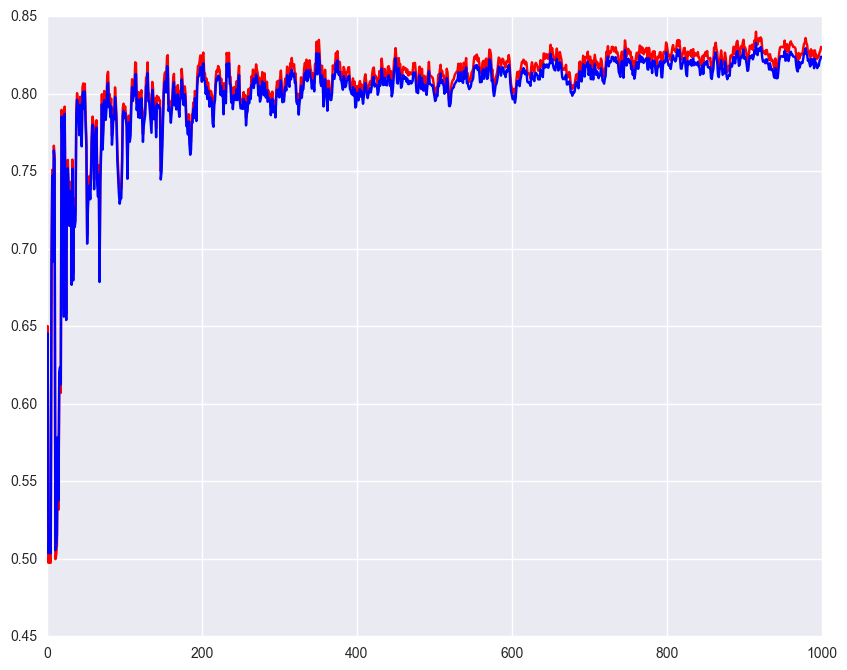

In [21]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучите вашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведите первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедитесь, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 


* Топ позитивных фичей перечислите через запятую под пунктом 1 в письме с кодом.

* Топ негативных фичей перечислите через запятую под пунктом 1 в письме с кодом.


**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [28]:
vectorizer = TfidfVectorizer(min_df=1, max_features=3000)
tfidfed = vectorizer.fit_transform(review_summaries)
X = tfidfed
y = train_df.Prediction.values

# Обучите модель
clf = LogisticRegression()
clf.train(X, y, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x110902f80>

In [36]:
sorted_idx = np.argsort(clf.w)

features = np.array(vectorizer.get_feature_names())

# Получите индексы фичей
pos_features = features[sorted_idx[-5:]]
neg_features = features[sorted_idx[:5]]

In [37]:
# Выведите слова
print pos_features, neg_features

[u'excellent' u'delicious' u'love' u'best' u'great'] [u'not' u'disappointed' u'bad' u'too' u'but']


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [38]:
from sklearn import linear_model

In [39]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.924
Test accuracy = 0.896


## 6. Что дальше?
* Нам повезло, что классы в нашем датасете сбалансированы. Какие проблемы возникнут у логистической регрессии, если, скажем, будет 90% нулевого класса и 10% первого. Как нужно изменить код, чтобы исправить эту проблему? Постарайтесь придумать не менее 2х способов.
* Почему мы не делаем регуляризацию для bias term в весах? Может, все таки, в каких-то случаях ее стоит делать?

Ответы на вопросы напишите здесь.

-----
<h1 align='center'>Part 2: Boosting</h1>

### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 


$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Как в итоге обучать**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}} = \frac{\partial L(\sum_{j=0}^{i-1} a_j b_j(x),~~y)}{\partial \sum_{j=0}^{i-1} a_j b_j(x)}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$
    - Подбираем $a_i$ -- одномерной минимизацией 
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + a_i b_i(x)$

## 1. Simple test

-----
** Реализуйте код в модуле ```dmia.classifiers.binary_boosting```.**

-----

In [24]:
from dmia.classifiers import BinaryBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from dmia.utils import plot_surface

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

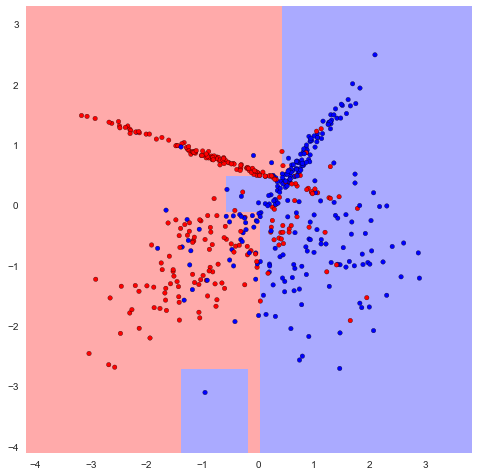

In [106]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
plot_surface(X, y, clf)

## 2. Outliers

Посмотрим на выбросы.

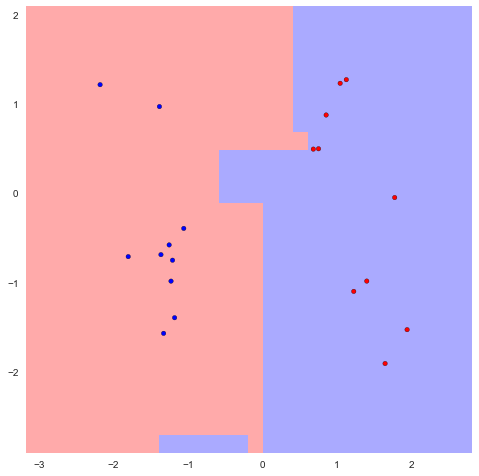

In [107]:
outliers_indices = clf.out_
plot_surface(X[outliers_indices], y[outliers_indices], clf)

## 3. Sentiment

Вы обучали логистическую регрессию на 1000+ фичах и это было быстро.

Как вы думаете, разумно ли обучать бустинг над деревьями на 1000 фичах? А на 10000? 100000? Обоснуйте ответ в каждом случае. Если не разумно, то что можно предпринять?

Ответ напишите ниже.

In [29]:
clf = BinaryBoostingClassifier(n_estimators=100, max_depth=3).fit(X_train, y_train)

print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.497
Test accuracy = 0.504


## 4. Посмотрим на ```feature_importances_```

* Обучите бустинг **на всех данных**, обработав ```review_summaries``` с помощью ```TfidfVectorizer``` с ```max_features=1000```.

* Параметры модели возьмите ```lr=0.1, n_estimators=100, max_depth=3```.

* Найдите топ-10 самых важных фичей с точки зрения алгоритма.

* Перечислите эти 10 слов через запятую под пунктом 3 в своем письме с кодом.

In [43]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidfed = vectorizer.fit_transform(review_summaries)

clf = BinaryBoostingClassifier(n_estimators=100, max_depth=3)
clf.fit(tfidfed, train_df.Prediction.values)

BinaryBoostingClassifier(lr=0.1, max_depth=None, n_estimators=100)

In [34]:
most_imp_features = ...

In [ ]:
# Напечатайте слова
...

## 5. Сравнение с sklearn.ensemble.GradientBoostingClassifier

Обучите градиентный бустинг из ```sklearn``` и сравните его качество на ```X_test``` с вашим (Оно не должно отличаться на много процентов! Вы образали деревья?)

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = ...

In [ ]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))